In [1]:
%load_ext autoreload
%autoreload 2

"""
In this file we conduct the multithat affinity analysis:
- we set up labels for the multithat examples (manual work outside of this)
- then we set up experiment to get affinities for the sentences
- then we run the multithat analysis
"""


'\nIn this file we conduct the multithat affinity analysis:\n- we set up labels for the multithat examples (manual work outside of this)\n- then we set up experiment to get affinities for the sentences\n- then we run the multithat analysis\n'

In [2]:
from rozlib.libs.common.data.utils_jsonl import read_from_jsonl
from typing import List



# read data from cluster


In [3]:
from lib.exp_common.mlm_result_for_sentence import MLMResultForSentence


def read_mlm_results() -> List[MLMResultForSentence]:
    # jsd_f = "./data/multithat_rozner_text_only.jsonl"
    jsd_f = Exp1Zhou.cec_multithat_affinities

    results = read_from_jsonl(jsd_f, MLMResultForSentence)
    return results

mlm_results = read_mlm_results()
print(len(mlm_results))
# print(mlm_results[0])



30


In [4]:
for i, m in  enumerate(mlm_results):
    print(i, m.sentence)

0 Marie is so amazed with his idea that she suggested that he publish it.
1 The man was so annoyed that he slept hungry and the next morning he chewed so much of a plant that he took on Shaman powers.
2 The man was so annoyed that he slept hungry and the next morning he chewed so much of a plant that he took on Shaman powers.
3 He was so concerned that there were provisions in the bill that were open to abuse that he voted against it.
4 Susan feels so guilty that Mike fell asleep at the reception due to all the night jobs he has done for her plans, that she asks the reverend if he has time later that night.
5 For example, Zhu Youliang the Prince of Heng, an older cousin of the emperor's, was so honored at court at that time that even Li Yu's superior, the chief of staff Li Zhen, kneeled to him.
6 He was so impressed that he started a craze for the test that has never diminished.
7 He was so indebted that he sold his Irish estates and used that money to invest in South Sea Company stock

In [5]:
from paper.exp1_zhou.exp1_utils import ResultWrapper
from data_config import Exp1Zhou
# note adapted from exp5_utils

from rozlib.libs.common.data.utils_dataclass import read_csv_to_dataclass
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import BaseExample
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import get_clean_exs

# all_exs = get_clean_exs(print_errors=True)
all_exs = get_clean_exs(Exp1Zhou.zhou_original_xlsx)
# multi_that_exs = read_csv_to_dataclass(BaseExample, data_dir/"multithat_rozner.csv")
multi_that_exs = read_csv_to_dataclass(BaseExample, Exp1Zhou.cec_multithat_rozner)
# modify in place -> eg fix str issues
[e._fix_self_for_csv_read() for e in multi_that_exs]



# helpers to retrieve, as like a database
def get_ex_with_same_sent(sent: str):
    for e in multi_that_exs:
        if e.sentence_punct_fixed == sent:
            return e
    raise Exception

def get_result_for_id(id) -> MLMResultForSentence:
    """
    id -> sent  -> mlm result

    """
    target_e_list = [e for e in all_exs if e.id == id]
    assert len(target_e_list) == 1
    target_e = target_e_list[0]

    tgt_result_list = [m for m in mlm_results if m.sentence == target_e.sentence_punct_fixed]
    assert len(tgt_result_list) == 1
    tgt_result = tgt_result_list[0]

    return tgt_result

def align_mlm_results_with_input_data(
        mlm_results: List[MLMResultForSentence],
) -> List[ResultWrapper]:
    """
    Return a list of aligned results:
    For every entry in mlm_result, finds the appropriate input BaseExample
    """
    all_aligned_results = []

    for m in mlm_results:
        s = m.sentence
        ex = get_ex_with_same_sent(s)
        all_aligned_results.append(ResultWrapper(
            ex,
            m
        ))

    return all_aligned_results

all_aligned_results = align_mlm_results_with_input_data(mlm_results)

# 30/31 - so we had one error as expected with messed up quotes
print(len(all_aligned_results), len(multi_that_exs))



While processing, 38 errors
Initially read in 323 examples
30 31


# "run" the experiment
Check that the correct that has the highest score

In [10]:
import math
def get_stat_for_thats_single_example(aligned_res: ResultWrapper):
    words = aligned_res.orig_example.sentence_punct_fixed.split(" ")
    all_that_idxs = [i for i,w in enumerate(words) if w.lower() == "that"]

    assert aligned_res.orig_example.that_idx in all_that_idxs, aligned_res
    assert len(all_that_idxs) > 1

    # extract scores for each of the so-thats
    m = aligned_res.mlm_result.score_matrix_distribution
    so_idx = aligned_res.orig_example.so_idx
    target_that_idx = aligned_res.orig_example.that_idx
    scores = dict()
    for that_idx in all_that_idxs:
        # we need the column
        scores[that_idx] = m[that_idx][so_idx]
    max_aff_score = max(scores.values())
    target_that_score = scores[target_that_idx]
    is_correctly_classified = math.isclose(max_aff_score, target_that_score)

    # also score by sorting and assert our approach worked
    scores_and_idxes = [(that_idx, score) for that_idx, score in scores.items()]
    sorted_scores = sorted(scores_and_idxes, key=lambda x: x[1], reverse=True)
    # assert added bc we know the method is perfect
    assert sorted_scores[0][0] == target_that_idx

    diffs = [target_that_score - scores[i] for i in all_that_idxs if i!= target_that_idx]

    return is_correctly_classified, diffs




def get_stats_for_thats():
    all_diffs = []
    orig_example_pointers = []
    ct_correct = 0
    for i, res in enumerate(all_aligned_results):
        # print(i)
        is_correct, diffs = get_stat_for_thats_single_example(res)
        ct_correct += is_correct
        all_diffs.extend(diffs)
        orig_example_pointers.extend([res.orig_example.id]*len(diffs))

    return ct_correct, all_diffs, orig_example_pointers

# can print which examples have the smallest diffs
ct, diffs, orig_example_pointers = get_stats_for_thats()
print(ct)
print(sorted([round(x,4) for x in diffs]))

# print(list(zip(diffs, orig_example_pointers)))


# for each we're going to see if the correct that is highlighted

30
[0.0003, 0.001, 0.0017, 0.0019, 0.0019, 0.0019, 0.0019, 0.0029, 0.0029, 0.0057, 0.0057, 0.0067, 0.0072, 0.0096, 0.0128, 0.0156, 0.0173, 0.0173, 0.0184, 0.0189, 0.0215, 0.0247, 0.0295, 0.0398, 0.0666, 0.0714, 0.0717, 0.1024, 0.1713, 0.2387, 0.3195, 0.3196, 0.36, 0.36, 0.6155, 0.6795]


When he nevertheless published a second edition in 1794, the censor was so irate that he arranged for a royal order that required Kant never to publish or even speak publicly about religion.


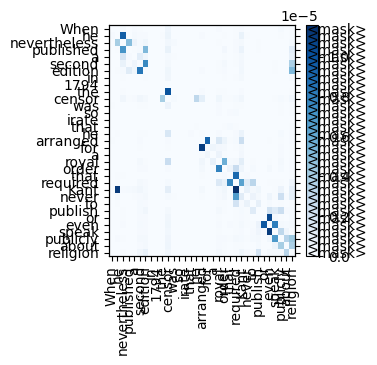

hello
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


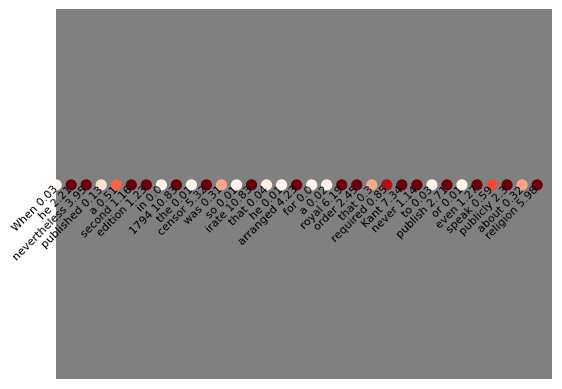

In [31]:
# if you want to visualize particular results
from lib.exp_common.data_processing_common import plot_from_mlm_result

m = get_result_for_id(84)
print(m.sentence)
plot_from_mlm_result(m)

In [32]:
"""
Enable local example testing
"""
from lib.scoring_fns import surprisal
from lib.exp_common.corr_matrix import get_scores
from lib.distr_diff_fcns import jensen_shannon_divergence

# local example testing
def compute_score_matrix(
        sent: str,
) -> List[List[float]]:
    dist_fn = jensen_shannon_divergence

    subs_list = ["<mask>"] * len(sent.split())

    scores, new_sents, multi_tok_indices, sent_word_list, hhis, preds, probs, actual_subs = get_scores(
        sent,
        subs_list,
        score_fn = surprisal ,
        subs_method="related",
        num_preds=1,
        dist_diff_fn=dist_fn
    )
    print(f"multitoken indices are {multi_tok_indices}")

    return scores

# check that the scores match
def check_that(
        sent: str,
        m: List[List[float]],
        so_idx: int,
        target_that_idx: int,
        that_ct: int
):
    words = sent.split(" ")
    all_that_idxs = [i for i,w in enumerate(words) if w.lower() == "that"]
    assert target_that_idx in all_that_idxs
    assert words[so_idx] == "so"
    assert len(all_that_idxs) == that_ct

    # extract scores for each of the so-thats
    scores = dict()
    for that_idx in all_that_idxs:
        # we need the column
        scores[that_idx] = m[that_idx][so_idx]
    print(scores)
    max_aff_score = max(scores.values())
    target_that_score = scores[target_that_idx]
    is_correctly_classified = math.isclose(max_aff_score, target_that_score)
    assert is_correctly_classified

    # also score by sorting and assert our approach worked
    scores_and_idxes = [(that_idx, score) for that_idx, score in scores.items()]
    sorted_scores = sorted(scores_and_idxes, key=lambda x: x[1], reverse=True)
    assert sorted_scores[0][0] == target_that_idx

    # diffs = [target_that_score - scores[i] for i in all_that_idxs if i!= target_that_idx]

    # return is_correctly_classified, diffs





# particularly hard example

In [33]:
from paper.exp1_zhou_multithat.helpers import str_with_indexes

s = "John worked so hard on helping his friend improve his argument that the policy was bad and that America should adopt the resolution that the policy had failed that he was too tired to debate the topic that the policy had failed himself."
# s = "John worked so hard on helping his friend improve his argument that meritocracy was bad and that America should adopt the resolution that meritocracy had failed that he was too tired to debate the topic that meritocracy was bad himself."
# s = "For example, Zhu Youliang the Prince of Heng, an older cousin of the emperor's, was so honored at court at that time that even Li Yu's superior, the chief of staff Li Zhen, kneeled to him."
print(str_with_indexes(s))
scores = compute_score_matrix(s)


0 John 1 worked 2 so 3 hard 4 on 5 helping 6 his 7 friend 8 improve 9 his 10 argument 11 that 12 the 13 policy 14 was 15 bad 16 and 17 that 18 America 19 should 20 adopt 21 the 22 resolution 23 that 24 the 25 policy 26 had 27 failed 28 that 29 he 30 was 31 too 32 tired 33 to 34 debate 35 the 36 topic 37 that 38 the 39 policy 40 had 41 failed 42 himself.
multitoken indices are []


In [34]:
# meritocracy
check_that(s, scores, 2, 28, 5)

# zhu youliang
# check_that(s, scores, 15, 22, 2)


{11: tensor(1.9524e-06), 17: tensor(1.1306e-05), 23: tensor(0.0002), 28: tensor(0.0200), 37: tensor(8.8957e-06)}
